# Import libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#from transformers import BertModel, BertTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from tqdm import tqdm
import requests
import warnings
import torch
import re

import nltk
#nltk.download()
from nltk.corpus import stopwords



from sklearn import preprocessing



!pip install gdown
import gdown

import gzip

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [ ]:
!pip install hdbscan

In [ ]:
import hdbscan

In [ ]:
!pip install umap-learn

In [ ]:
from umap import UMAP

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [ ]:
from rpy2.robjects.packages import importr
utils = importr('utils')

In [ ]:
utils.install_packages('FCPS',repos="https://cloud.r-project.org")

In [ ]:
utils.install_packages('fastcluster',repos="https://cloud.r-project.org")

In [ ]:
utils.install_packages('clustrd',repos="https://cloud.r-project.org")

In [ ]:
base = importr ('base')
fcps = importr ( 'FCPS')

# Fontions utilitaires

In [ ]:
def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
                for chunk in response.iter_content(CHUNK_SIZE):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
                        bar.update(CHUNK_SIZE)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

if __name__ == "__main__":
    import sys
    if len(sys.argv) is not 3:
        print("Usage: python google_drive.py drive_file_id destination_file_path")
    else:
        # TAKE ID FROM SHAREABLE LINK
        file_id = sys.argv[1]
        # DESTINATION FILE ON YOUR DISK
        destination = sys.argv[2]
        download_file_from_google_drive(file_id, destination)

224kB [00:00, 270MB/s]


In [ ]:
token_pattern = r"(?u)\b\w\w+\b"
token_pattern = re.compile(token_pattern)

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def accuracy(true_row_labels, predicted_row_labels):
    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    # deprecated: indexes = linear_assignment(_make_cost_m(cm))
    indexes = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(*indexes):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))

def tokenize_re(text, min_len=2):
    tokens = token_pattern.findall(text)
    return [x for x in tokens if len(x) >= min_len]

def static_document_embeddings(word_embedding_func, docs, tokenizer, n_dims=300):
    """
        Given a set of tokenized sentences, compute the mean vector of w2v vectors for each sentence
    """
    doc_vectors = []
    for doc in docs:
        doc = tokenizer(doc)
        word_vectors = []
        for word in doc:
            vector = word_embedding_func(word)
            if vector is not None:
                word_vectors.append(vector)
        if word_vectors:
            doc_vector = np.array(word_vectors).mean(axis=0)
        else:
            warnings.warn("Zeros returned. Words not in vocabulary \"{}\"".format(doc), Warning)
            doc_vector = np.array([0] * n_dims)
        
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)


In [ ]:
def eval_clustering_2D(X_reduced, pred_labels, labels):
  plt.figure(figsize = (15, 8))
  nmi = normalized_mutual_info_score(labels,pred_labels )
  plt.suptitle('NMI = ' + str(normalized_mutual_info_score(labels,pred_labels )))
  #plt.suptitle('ACCURACY' + str(accuracy(labels,pred_labels)))
  #plt.suptitle('ACCURACY' + str(adjusted_rand_score(labels,pred_labels)))

  plt.subplot(1, 2, 1)
  plt.title("Predicted_labels")
  plt.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1],c = pred_labels)
  plt.subplot(1, 2, 2)
  plt.title("Labels")
  plt.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1], c = labels)

In [ ]:
def printMetrics(labels, pred_labels):
  print("normalized_mutual_info_score: ",round(normalized_mutual_info_score(pred_labels,labels), 2),"%")
  print("Accuracy: ",round(accuracy(labels,pred_labels),2),"%")
  print("Adjusted Rand Index: ",round(adjusted_rand_score(labels, pred_labels),2),"%")

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def autoencoder(X, embedding_dim, n_epochs=50, batch_size=64, learning_rate=1e-3, weight_decay=1e-8, seed=None, return_model=False):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    if seed is not None:
      torch.manual_seed(seed)

    dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)

    model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

    if device == 'cuda':
      model.cuda()

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)

    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
          batch = batch.to(device)
          reconstructed = model(batch)
        
          loss = loss_function(reconstructed, batch)
        
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
          losses.append(loss)

    model.eval()
    model.to("cpu")
    encoded_X = model.encoder(torch.tensor(X))
    encoded_X = encoded_X.detach().numpy()

    if return_model:
      return encoded_X, model, losses
    else:
      return encoded_X

In [ ]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

"""
  Credits:
    This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
    Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


#######################################################
############### Deep Clustering Network ###############
#######################################################

class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


#######################################################
##################### Deep K-means ####################
#######################################################

class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

# Import data 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Apprentissage et factorisation matricielle - Text Mining /bbc.csv")

In [ ]:
X

Unnamed: 0                                               text     label
0              0  England coach faces rap after row\n\nEngland c...     sport
1              1  Moody joins up with England\n\nLewis Moody has...     sport
2              2  Ferguson fears Milan cutting edge\n\nMancheste...     sport
3              3  Henry tipped for Fifa award\n\nFifa president ...     sport
4              4  Arnesen denies rift with Santini\n\nTottenham ...     sport
...          ...                                                ...       ...
2220        2220  Commons hunt protest charges\n\nEight proteste...  politics
2221        2221  UK set to cut back on embassies\n\nNine overse...  politics
2222        2222  'Few ready' for information act\n\nThousands o...  politics
2223        2223  Goldsmith: 'I was not leant on'\n\nThe attorne...  politics
2224        2224  Hewitt decries 'career sexism'\n\nPlans to ext...  politics

[2225 rows x 3 columns]

In [ ]:
labels = X['label']

In [ ]:
labels.unique()

array(['sport', 'entertainment', 'tech', 'business', 'politics'],
      dtype=object)

In [ ]:
labels = preprocessing.LabelEncoder().fit_transform(labels)

In [ ]:
texts = X['text'].apply(str)

In [ ]:
texts

0       England coach faces rap after row\n\nEngland c...
1       Moody joins up with England\n\nLewis Moody has...
2       Ferguson fears Milan cutting edge\n\nMancheste...
3       Henry tipped for Fifa award\n\nFifa president ...
4       Arnesen denies rift with Santini\n\nTottenham ...
                              ...                        
2220    Commons hunt protest charges\n\nEight proteste...
2221    UK set to cut back on embassies\n\nNine overse...
2222    'Few ready' for information act\n\nThousands o...
2223    Goldsmith: 'I was not leant on'\n\nThe attorne...
2224    Hewitt decries 'career sexism'\n\nPlans to ext...
Name: text, Length: 2225, dtype: object

In [ ]:
X.groupby('label').count()

Unnamed: 0  text
label                          
business              510   510
entertainment         386   386
politics              417   417
sport                 511   511
tech                  401   401

Les classes sont assez équilibrées.

# Word2Vec 

In [ ]:
code_drive_w2v = "1k0ZS3Z7hctHdf3t6NeH1skuFJWUL0TZM"

In [ ]:
download_file_from_google_drive(code_drive_w2v,"word2vec.bin.gz")

1.53GB [00:14, 114MB/s]


In [ ]:
w2v_model = KeyedVectors.load_word2vec_format("word2vec.bin.gz",binary=True)

In [ ]:
get_w2v_vector = lambda x:w2v_model[x] if x in w2v_model.vocab else None

In [ ]:
X_w2v = static_document_embeddings(get_w2v_vector,texts,tokenize_re)
X_w2v.shape

(2225, 300)

## Clustering sur Word2Vec

### Kmeans 

In [ ]:
pred_labels = KMeans(5, random_state = 42).fit(X_w2v).labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.8 %
Accuracy:  0.92 %
Adjusted Rand Index:  0.8 %


### Clustering spectral 

In [ ]:
pred_labels=SpectralClustering(5,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_w2v).labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.77 %
Accuracy:  0.75 %
Adjusted Rand Index:  0.65 %


### HDBSCAN

In [ ]:
X_w2v_sc = StandardScaler().fit_transform(X_w2v)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(X_w2v_sc)
pred_labels= hdbscan_model.labels_


In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.47 %
Accuracy:  0.53 %
Adjusted Rand Index:  0.18 %


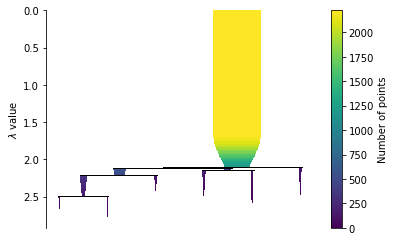

In [ ]:
hdbscan_model.condensed_tree_.plot()

### CAH 

In [ ]:
CAH = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X_w2v)
pred_labels= CAH.labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.79 %
Accuracy:  0.92 %
Adjusted Rand Index:  0.81 %


Hormis HDBSCAN, les approches de clustering sur l'espace d'origine nous donnent de bons résultats. Quant à HDBSCAN, ce dernier donne de mauvais résultas, cela peut être dû au fait que dans l'espace d'origine les données sont éloignées les unes des autres car le nombre de dimensions est assez grand, ce qui rend l'utilisation d'une méthode se basant sur la densité compliquée.

## Approches Tandem sur Word2Vec

### PCA 

In [ ]:
X_w2v_reduced = PCA(n_components=2, whiten=False, random_state=42).fit_transform(X_w2v)

#### Kmeans 

normalized_mutual_info_score:  0.56 %
Accuracy:  0.73 %
Adjusted Rand Index:  0.53 %


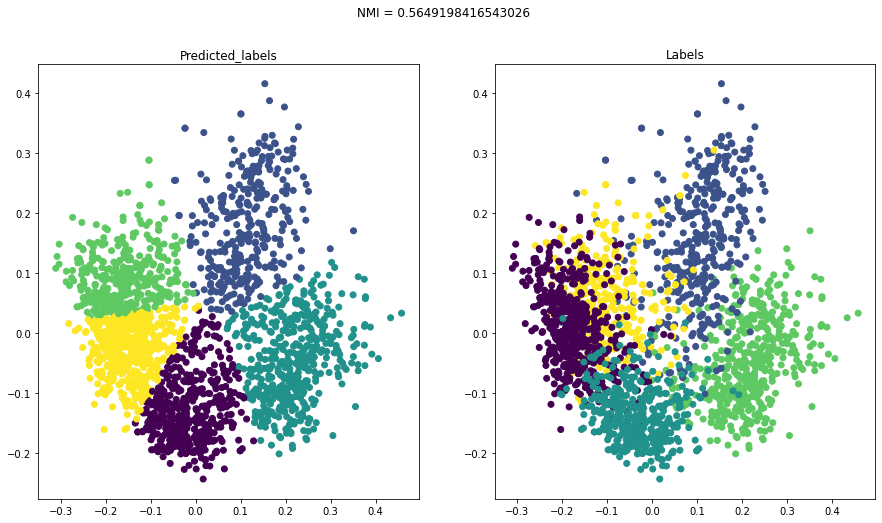

In [ ]:

pred_labels = KMeans(5,random_state=42).fit(X_w2v_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_reduced,pred_labels, labels)

La PCA n'a pas réussi à bien séparer les différents clusters dans l'espace réduit, ce qui va rendre le clustering difficile.

#### Clustering spectral 

normalized_mutual_info_score:  0.57 %
Accuracy:  0.74 %
Adjusted Rand Index:  0.53 %


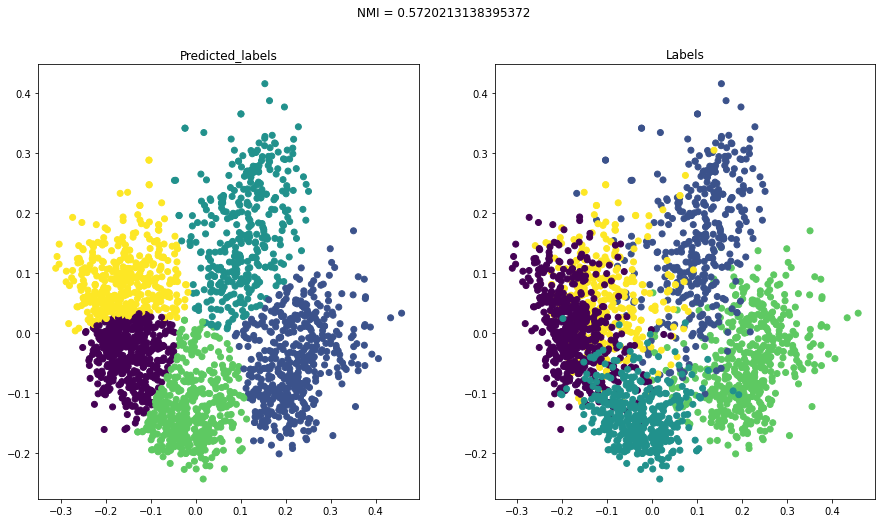

In [ ]:
pred_labels=SpectralClustering(5,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_w2v_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_reduced,pred_labels, labels)

#### HDBSCAN

normalized_mutual_info_score:  0.43 %
Accuracy:  0.52 %
Adjusted Rand Index:  0.28 %


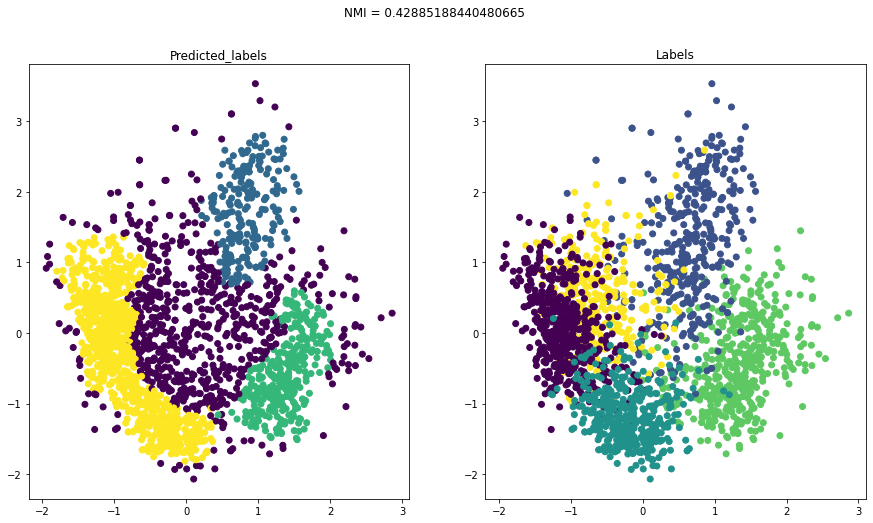

In [ ]:
X_w2v_reduced_sc = StandardScaler().fit_transform(X_w2v_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(X_w2v_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_reduced_sc,pred_labels, labels)


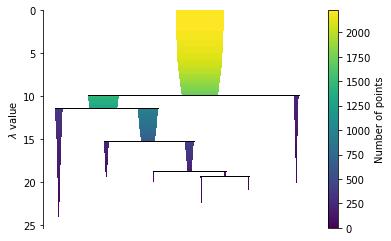

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### CAH

avec critère d'aggrégation ward

In [ ]:
CAH = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X_w2v_reduced)
pred_labels= CAH.labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.55 %
Accuracy:  0.67 %
Adjusted Rand Index:  0.49 %


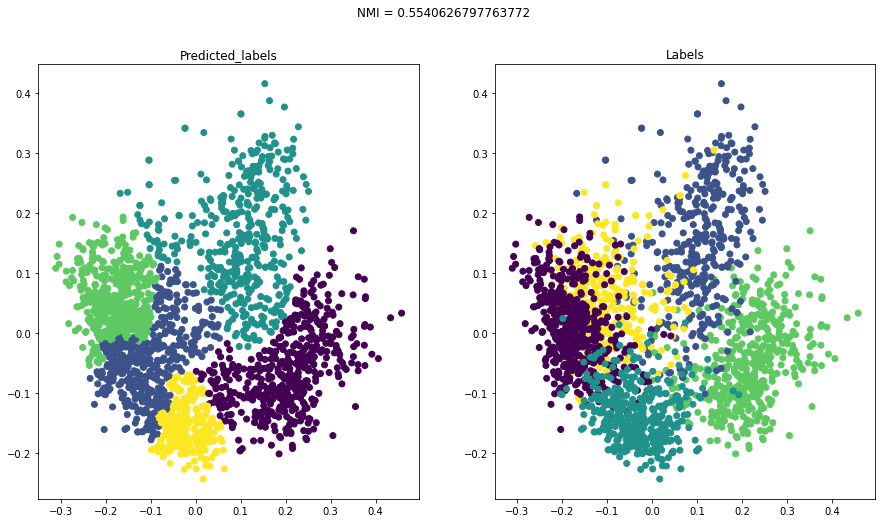

In [ ]:
eval_clustering_2D(X_w2v_reduced,pred_labels,labels)

### TSNE  

In [ ]:
X_w2v_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_w2v)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


#### Kmeans

In [ ]:
pred_labels = KMeans(5,random_state=42).fit(X_w2v_tsne).labels_
printMetrics(labels,pred_labels)

normalized_mutual_info_score:  0.85 %
Accuracy:  0.94 %
Adjusted Rand Index:  0.87 %


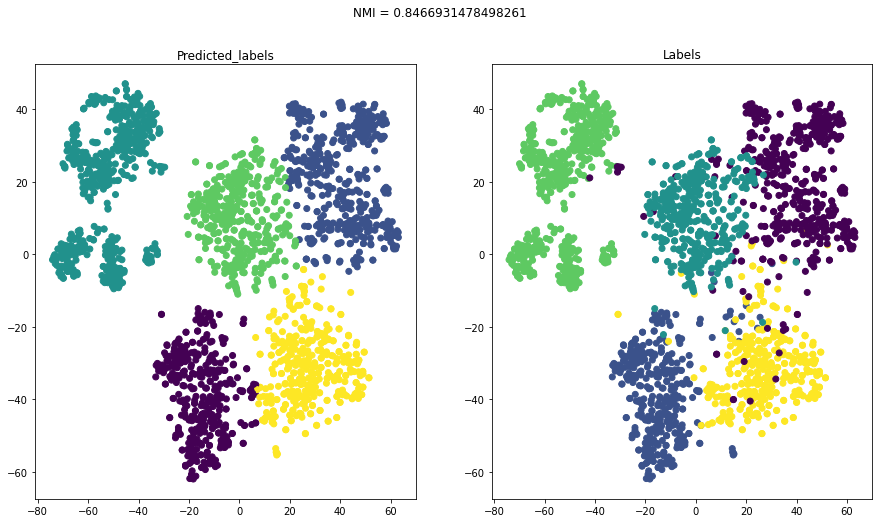

In [ ]:
eval_clustering_2D(X_w2v_tsne,pred_labels,labels)

TSNE a bien réussi à séparer les clusters.

#### Clustering spectral 

normalized_mutual_info_score:  0.76 %
Accuracy:  0.7 %
Adjusted Rand Index:  0.63 %


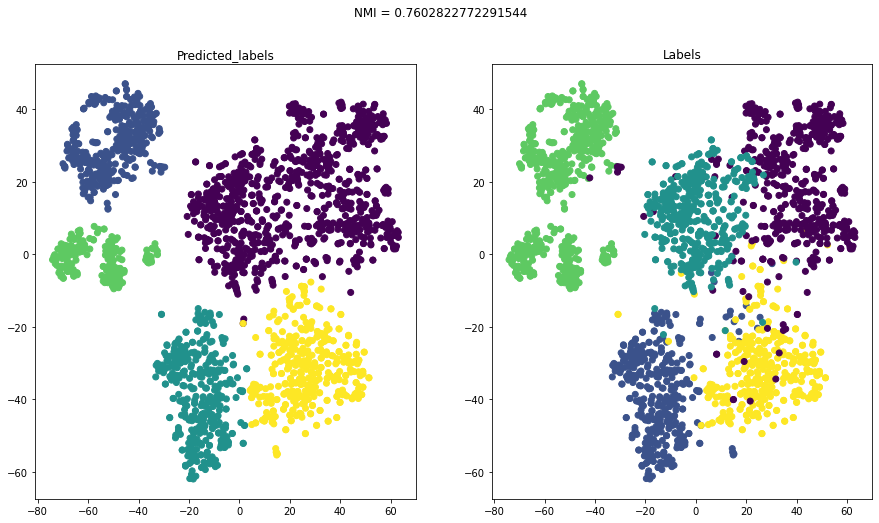

In [ ]:
pred_labels=SpectralClustering(5,affinity='nearest_neighbors',n_neighbors=50,random_state=42).fit(X_w2v_tsne).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_tsne,pred_labels, labels)

#### HDBSCAN

normalized_mutual_info_score:  0.69 %
Accuracy:  0.75 %
Adjusted Rand Index:  0.65 %


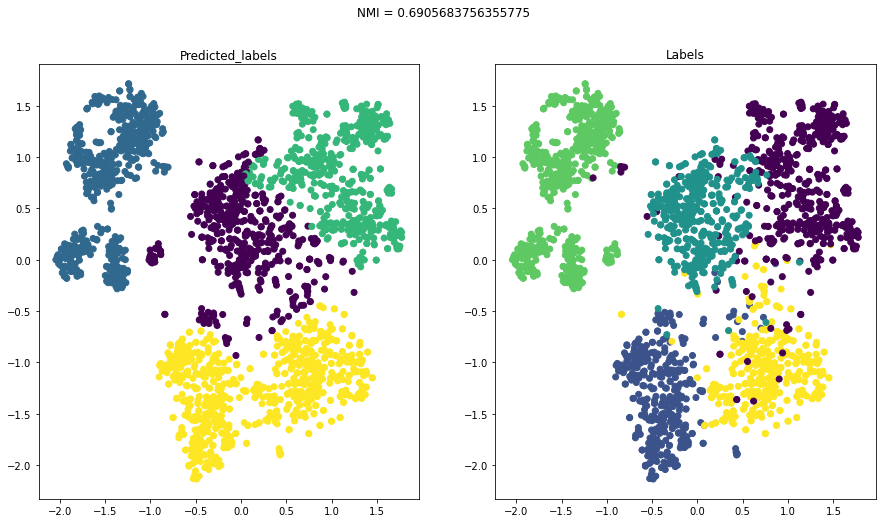

In [ ]:
X_w2v_tsne_sc = StandardScaler().fit_transform(X_w2v_tsne)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_w2v_tsne_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_tsne_sc,pred_labels, labels)


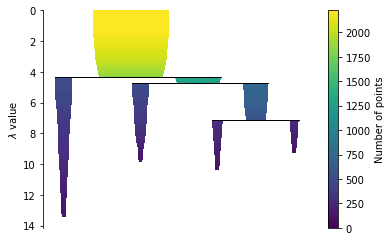

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### CAH

In [ ]:
CAH = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X_w2v_tsne)
pred_labels= CAH.labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.82 %
Accuracy:  0.93 %
Adjusted Rand Index:  0.84 %


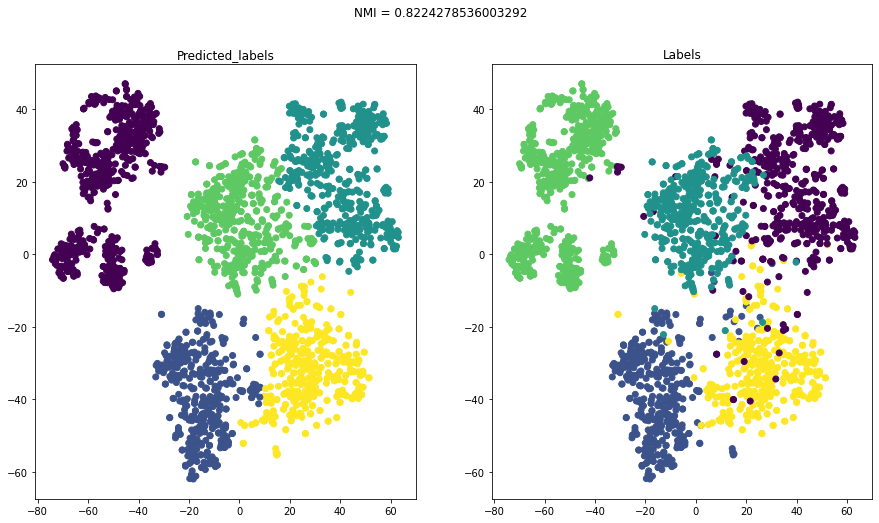

In [ ]:
eval_clustering_2D(X_w2v_tsne,pred_labels,labels)

### UMAP

In [ ]:
X_w2v_umap = UMAP(n_components=2, random_state=42).fit_transform(X_w2v)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


#### Kmeans

In [ ]:
pred_labels = KMeans(5,random_state=42).fit(X_w2v_umap).labels_
printMetrics(labels,pred_labels)

normalized_mutual_info_score:  0.87 %
Accuracy:  0.95 %
Adjusted Rand Index:  0.89 %


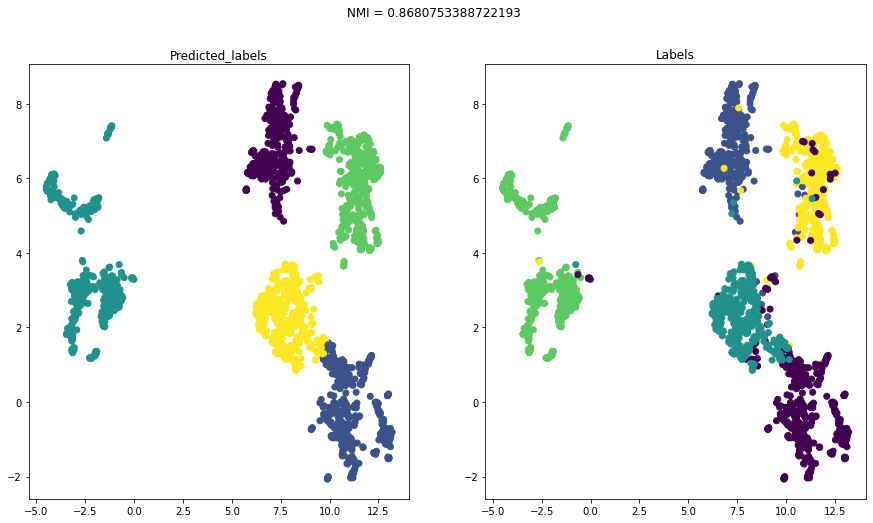

In [ ]:
eval_clustering_2D(X_w2v_umap,pred_labels,labels)

Avec UMAP, les clusters sont non seulement bien délimités, mais aussi éloignés les uns des autres.

#### Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.77 %
Accuracy:  0.7 %
Adjusted Rand Index:  0.64 %


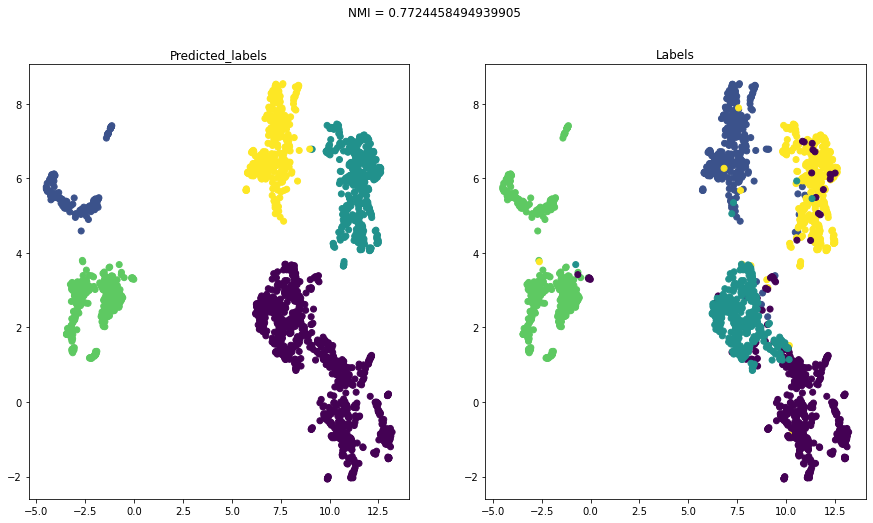

In [ ]:
pred_labels=SpectralClustering(5,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_w2v_umap).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_umap,pred_labels, labels)

#### HDBSCAN

normalized_mutual_info_score:  0.71 %
Accuracy:  0.64 %
Adjusted Rand Index:  0.6 %


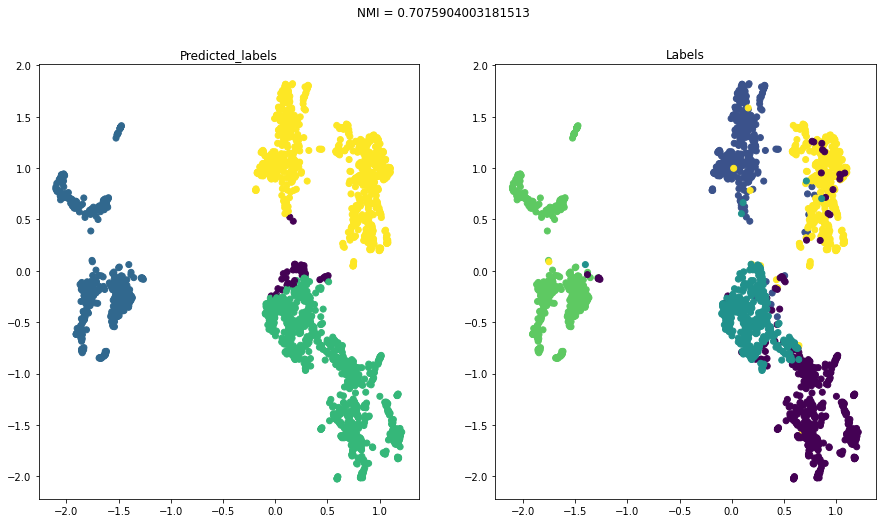

In [ ]:
X_w2v_umap_sc = StandardScaler().fit_transform(X_w2v_umap)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_w2v_umap_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_w2v_umap_sc,pred_labels, labels)


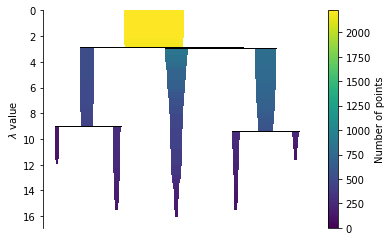

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### CAH

In [ ]:
CAH = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X_w2v_umap)
pred_labels= CAH.labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.85 %
Accuracy:  0.94 %
Adjusted Rand Index:  0.87 %


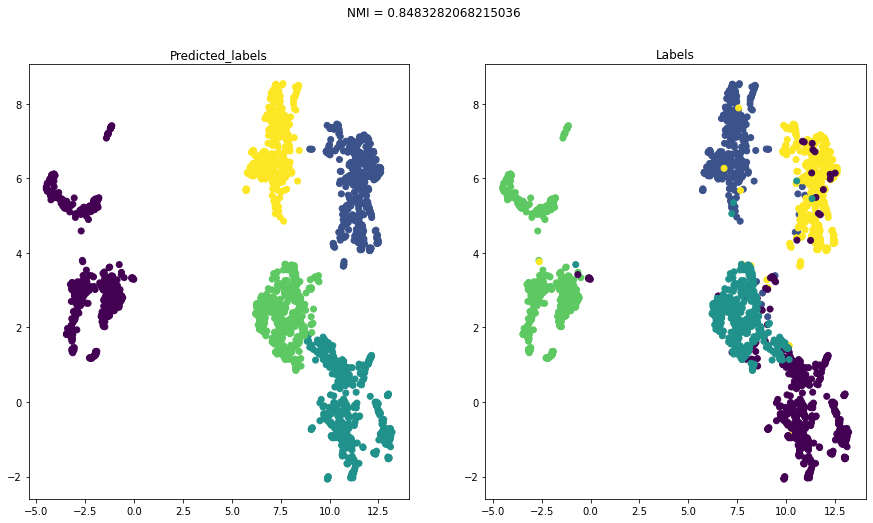

In [ ]:
eval_clustering_2D(X_w2v_umap,pred_labels,labels)

### Autoencoders

In [ ]:
encoded_X_w2v = autoencoder(X_w2v,2,seed=42)

100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


#### Kmeans

In [ ]:
pred_labels = KMeans(5,random_state=42).fit(encoded_X_w2v).labels_
printMetrics(labels,pred_labels)

normalized_mutual_info_score:  0.42 %
Accuracy:  0.52 %
Adjusted Rand Index:  0.32 %


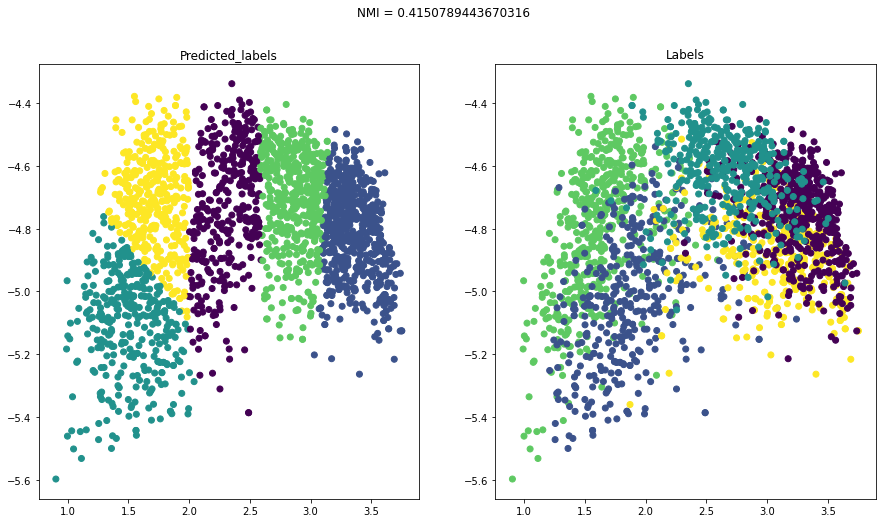

In [ ]:
eval_clustering_2D(encoded_X_w2v,pred_labels,labels)

L'espace réduit obtenu avec l'autoencoder est de mauvaise qualité, les clusters sont les uns dans les autres. Un meilleur tuning de l'autoencoder permettrait peut-être d'améliorer ces résultats.

#### Clustering spectral 

normalized_mutual_info_score:  0.39 %
Accuracy:  0.51 %
Adjusted Rand Index:  0.27 %


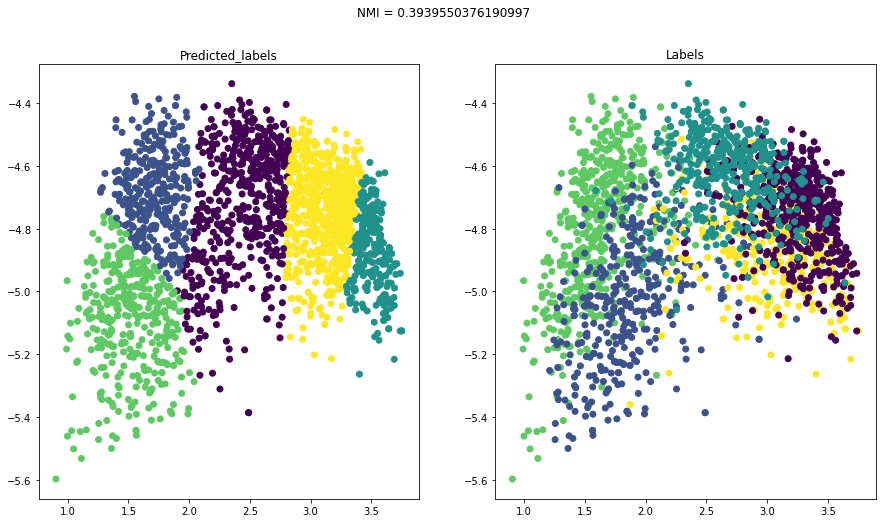

In [ ]:
pred_labels=SpectralClustering(5,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(encoded_X_w2v).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(encoded_X_w2v,pred_labels, labels)

#### HDBSCAN

normalized_mutual_info_score:  0.35 %
Accuracy:  0.45 %
Adjusted Rand Index:  0.21 %


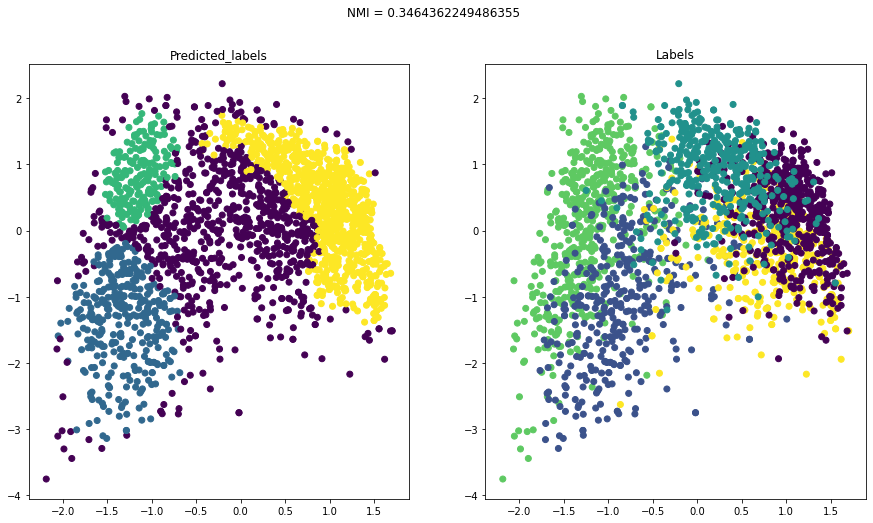

In [ ]:
encoded_X_w2v_sc = StandardScaler().fit_transform(encoded_X_w2v)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(encoded_X_w2v_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(encoded_X_w2v_sc,pred_labels, labels)


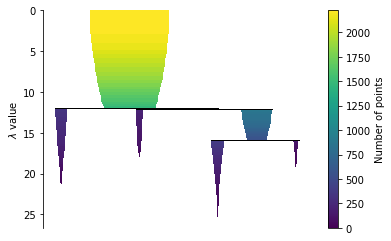

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### CAH

In [ ]:
CAH = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(encoded_X_w2v)
pred_labels= CAH.labels_

In [ ]:
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.42 %
Accuracy:  0.54 %
Adjusted Rand Index:  0.34 %


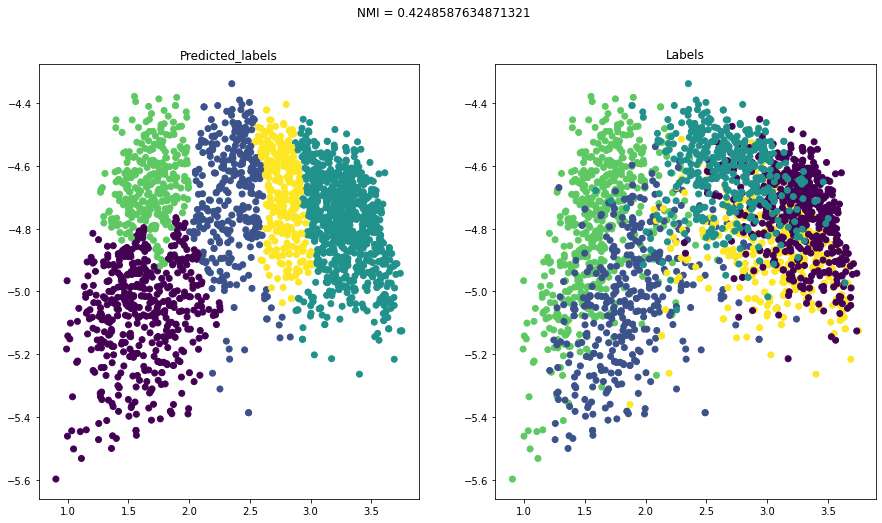

In [ ]:
eval_clustering_2D(encoded_X_w2v,pred_labels,labels)

### Conclusion sur les approches Tandem

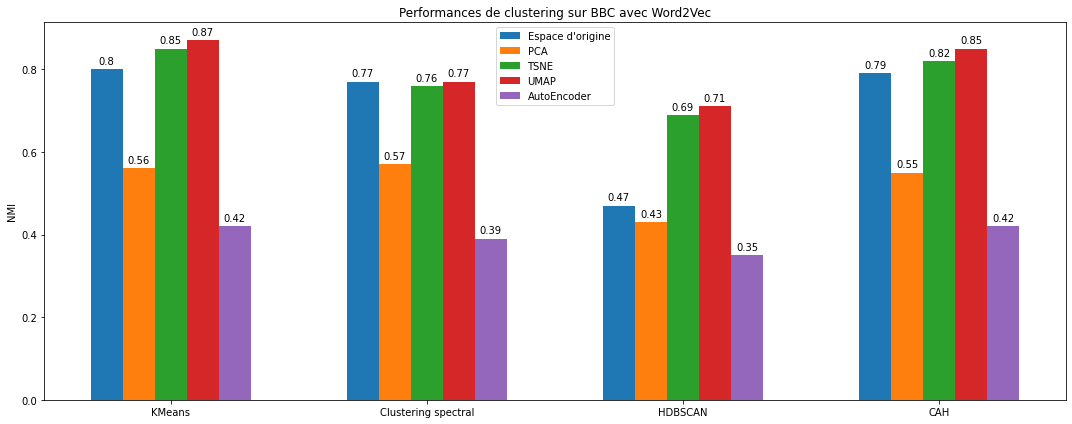

In [ ]:
clust_base = [0.80, 0.77, 0.47, 0.79]
pca_clust = [0.56, 0.57, 0.43, 0.55]
tsne_clust = [0.85, 0.76, 0.69, 0.82]
umap_clust = [0.87, 0.77, 0.71, 0.85]
autoenc_clust = [0.42, 0.39, 0.35, 0.42]
compareNMI(clust_base, pca_clust, tsne_clust, umap_clust, autoenc_clust, "Performances de clustering sur BBC avec Word2Vec")

KMeans et CAH ont des performances assez similaires. HDBSCAN a de mauvais résultats. UMAP apparaît comme le meilleur algorithme de réduction de dimension. 

## Approches combinées 

### Reduced k-means 

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%normalized_mutual_info_score:  0.72 %
Accuracy:  0.87 %
Adjusted Rand Index:  0.72 %


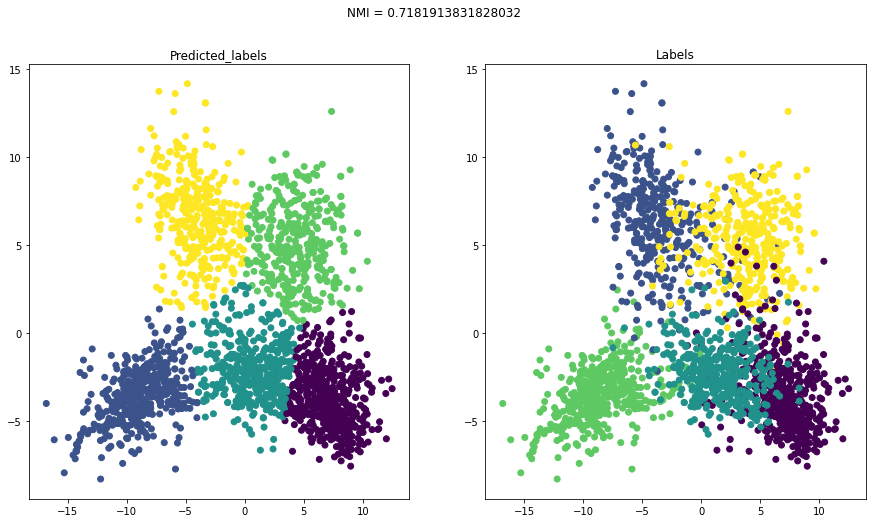

In [ ]:
rkm = fcps.TandemClustering(X_w2v,5,Type='Reduced', PlotIt=False,ndim=2,nstart=10)
pred_labels = rkm[0]
reduced_X_w2v = rkm[1][0]
printMetrics(labels, pred_labels)
eval_clustering_2D(reduced_X_w2v,pred_labels,labels)

Reduced KM obtient des performances convenables, mais en deça ce qu'on a pu obtenir avec les approches tandem.

### Factorial k-means 

  |======================================================================| 100%normalized_mutual_info_score:  0.38 %
Accuracy:  0.57 %
Adjusted Rand Index:  0.3 %


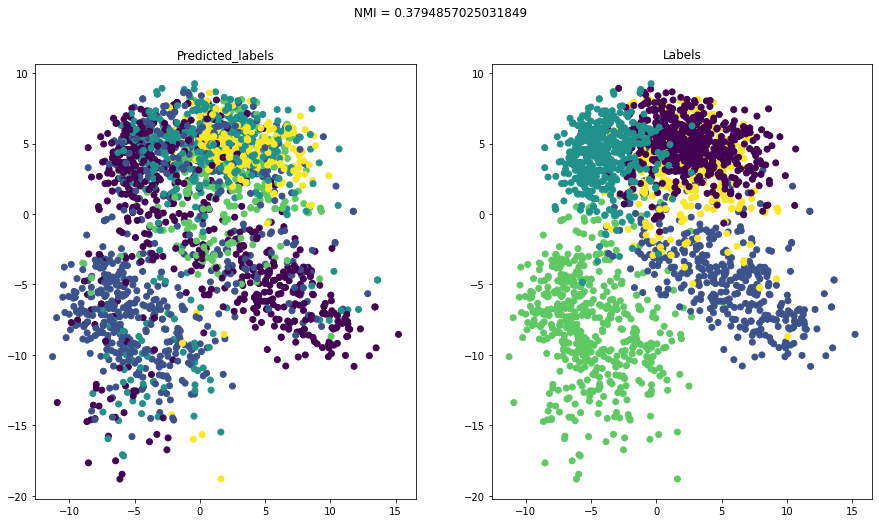

In [ ]:
rkm = fcps.TandemClustering(X_w2v,5,Type='Factorial', PlotIt=False,ndim=2,nstart=10)
pred_labels = rkm[0]
Reduced_X_w2v = rkm[1][0]
printMetrics(labels, pred_labels)
eval_clustering_2D(Reduced_X_w2v,pred_labels,labels)

Factorial KM n'a pas bien fonctionné, la NMI est faible et les clusters assez emmêlés dans l'espace réduit

### Deep Clustering Network

In [ ]:
embeddings, cluster_assign_ = DCN(X_w2v, n_clusters=5,n_components=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.05it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


normalized_mutual_info_score:  0.71 %
Accuracy:  0.68 %
Adjusted Rand Index:  0.6 %


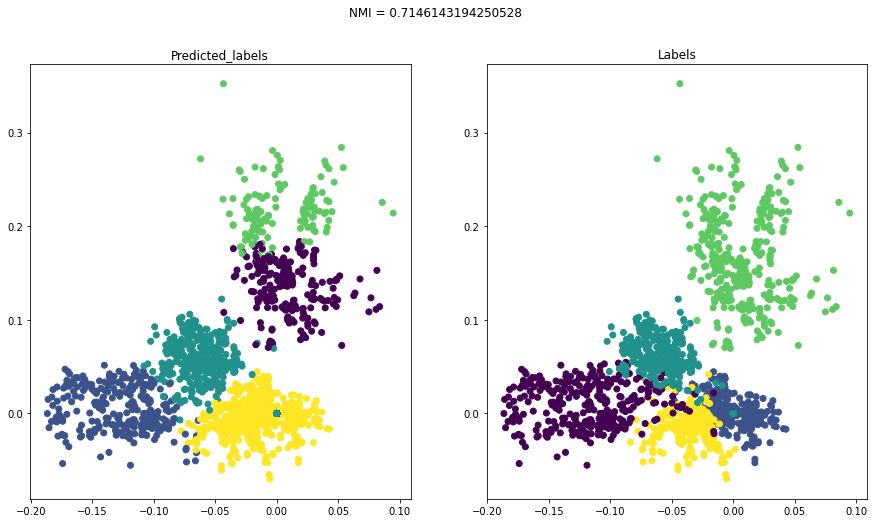

In [ ]:
printMetrics(labels, cluster_assign_)
eval_clustering_2D(embeddings,cluster_assign_,labels)

### Deep k-means

In [ ]:
tf.reset_default_graph()

In [ ]:
X_reduced, cluster_assign = DKM(X_w2v,n_clusters=5,n_components=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


normalized_mutual_info_score:  0.71 %
Accuracy:  0.68 %
Adjusted Rand Index:  0.6 %


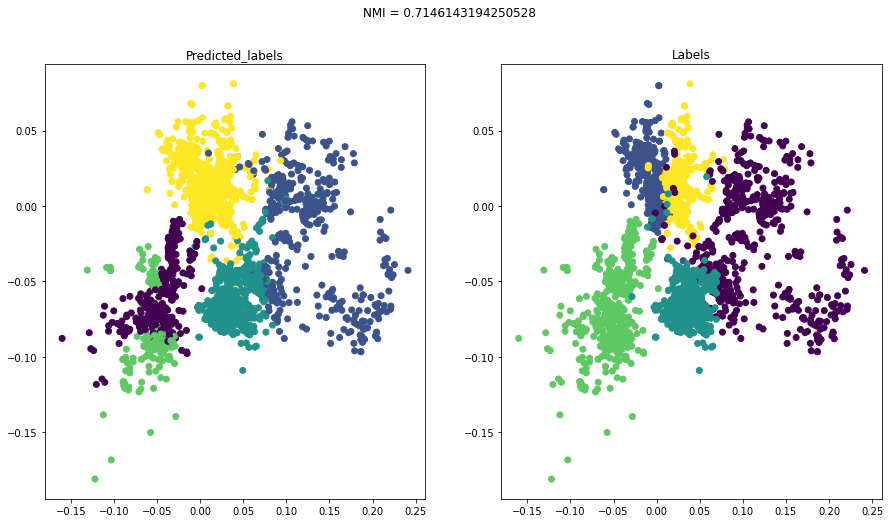

In [ ]:
printMetrics(labels, cluster_assign_)
eval_clustering_2D(X_reduced,cluster_assign_,labels)

### Performances des approches combinées

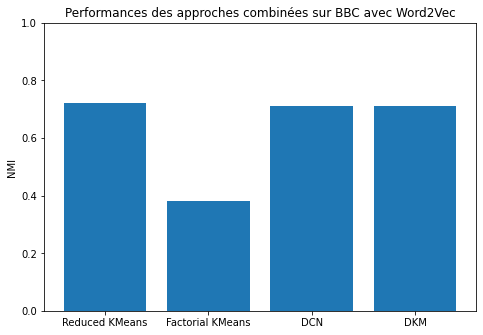

In [ ]:
perfs = [0.72, 0.38, 0.71, 0.71]
compareCombined(perfs, "Performances des approches combinées sur BBC avec Word2Vec")

Reduced KM, DCN et DKM obtiennent autour des résultats intéressants mais plus faibles que les meilleurs résultats des approches tandem. Un tuning plus approfondi de ces méthodes combinées permettrait sans doute d'améliorer les résultats.

# Glove

## Import du modèle Glove

In [ ]:
!pip install gdown
import gdown
import gzip

In [ ]:
url_glove = 'https://nlp.stanford.edu/data/glove.840B.300d.zip'
gdown.download(url_glove, quiet=False, output='glove.zip')

Downloading...
From: https://nlp.stanford.edu/data/glove.840B.300d.zip
To: /content/glove.zip
100%|██████████| 2.18G/2.18G [06:52<00:00, 5.28MB/s]


'glove.zip'

In [ ]:
!unzip glove.zip

Archive:  glove.zip
  inflating: glove.840B.300d.txt     


In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/glove.840B.300d.txt')
tmp_file = get_tmpfile("/content/glove.w2v.txt")
_ = glove2word2vec(glove_file, tmp_file)
glove_model = KeyedVectors.load_word2vec_format(tmp_file)

##Création de l'embedding Glove

In [ ]:
get_glove_vector = lambda x: glove_model[x] if x in glove_model.vocab else None

In [ ]:
X_glove = static_document_embeddings(get_glove_vector, texts, tokenize_re)
X_glove.shape

(2225, 300)

## Clustering sur l'espace d'origine

In [ ]:
k = 5 #BBC

### KMeans

In [ ]:
pred_labels = KMeans(k,random_state=42).fit(X_glove).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.74 %
Accuracy:  0.9 %
Adjusted Rand Index:  0.76 %


### Spectral Clustering

In [ ]:
pred_labels=SpectralClustering(k,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_glove).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.79 %
Accuracy:  0.91 %
Adjusted Rand Index:  0.79 %


### HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 11.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311989 sha256=aa891a157ad2980dd91ef8b9a6fb659c0eebadad386c3dbd8918280ee0c6c952
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
from sklearn.preprocessing import StandardScaler
X_glove_sc = StandardScaler().fit_transform(X_glove)
#from sklearn.metrics import pairwise_distances
#distance = pairwise_distances(X_glove, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=25, metric='braycurtis').fit(X_glove_sc)

#pred_labels = hdbscan_model.fit(distance.astype('float64')).labels_

pred_labels = hdbscan_model.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.42 %
Accuracy:  0.5 %
Adjusted Rand Index:  0.18 %


In [ ]:
np.unique(pred_labels)

array([-1,  0,  1,  2,  3])

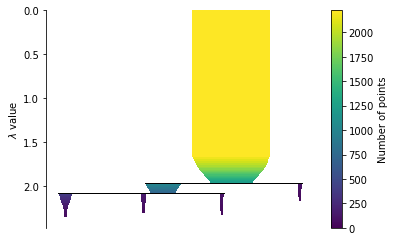

In [ ]:
hdbscan_model.condensed_tree_.plot()

### CAH

In [ ]:
from sklearn.cluster import AgglomerativeClustering

pred_labels = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(X_glove).labels_
#CAH = AgglomerativeClustering().fit(X_w2v_reduced)
#pred_labels= CAH.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.73 %
Accuracy:  0.85 %
Adjusted Rand Index:  0.67 %


## Approches Tandem

### PCA 

In [ ]:
acp = PCA(n_components=2, random_state=42)
X_glove_reduced = acp.fit_transform(X_glove)
acp.explained_variance_.sum()

0.26410824

#### PCA + Kmeans 

normalized_mutual_info_score:  0.41 %
Accuracy:  0.55 %
Adjusted Rand Index:  0.33 %


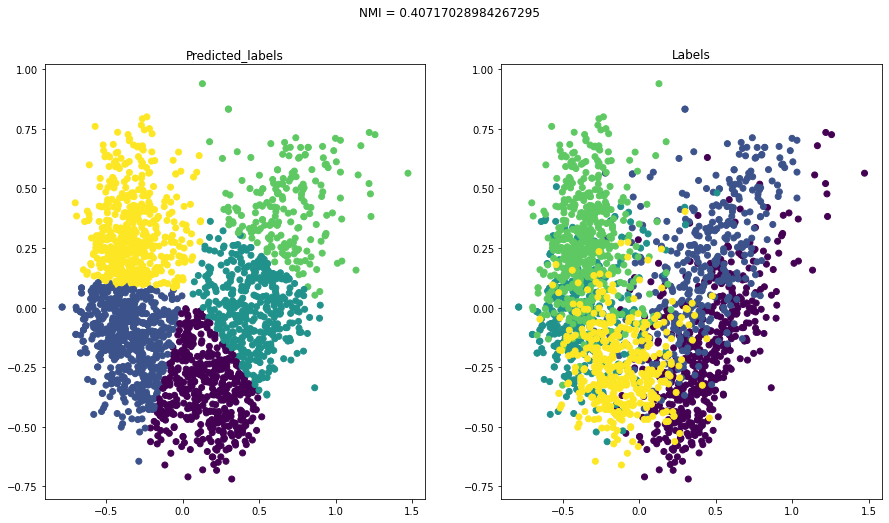

In [ ]:
pred_labels = KMeans(k,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

La PCA avec 2 composantes principales ne nous donne pas un espace réduit très satisfaisant (les différentes classes ne sont pas bien séparées), en partie dû à un pourcentage de variance expliqué faible (26%). Il faut donc s'attendre à des performances médiocres quand on fait du clustering sur cet espace réduit.

#### PCA + Clustering spectral 

normalized_mutual_info_score:  0.43 %
Accuracy:  0.64 %
Adjusted Rand Index:  0.36 %


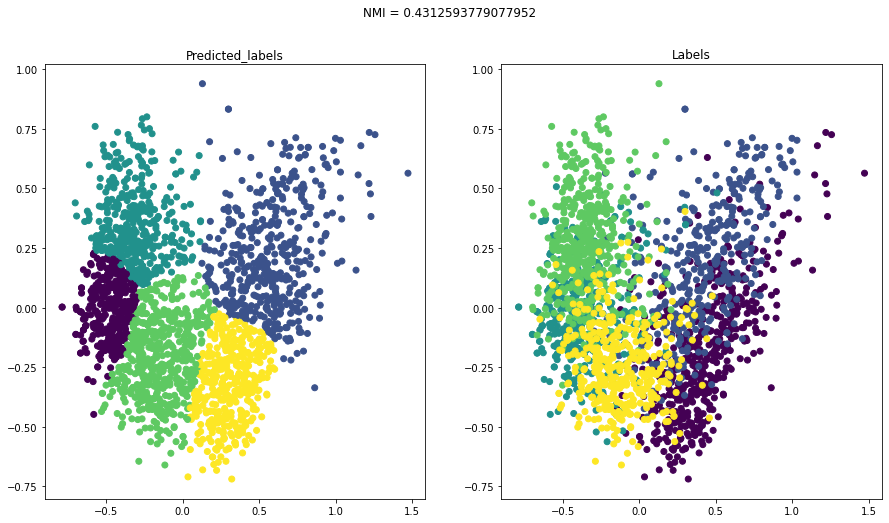

In [ ]:
pred_labels=SpectralClustering(k,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

#### PCA + HDBSCAN

normalized_mutual_info_score:  0.33 %
Accuracy:  0.5 %
Adjusted Rand Index:  0.17 %


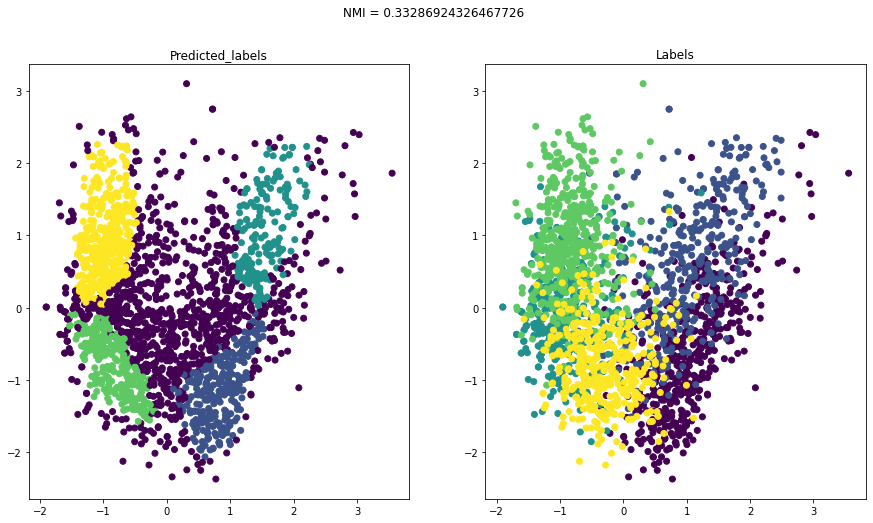

In [ ]:
X_glove_reduced_sc = StandardScaler().fit_transform(X_glove_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(X_glove_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced_sc,pred_labels, labels)


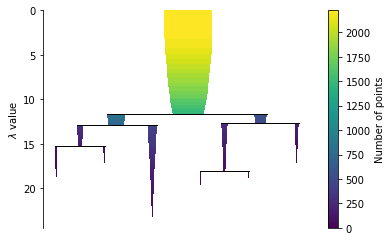

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### PCA + CAH

normalized_mutual_info_score:  0.42 %
Accuracy:  0.53 %
Adjusted Rand Index:  0.34 %


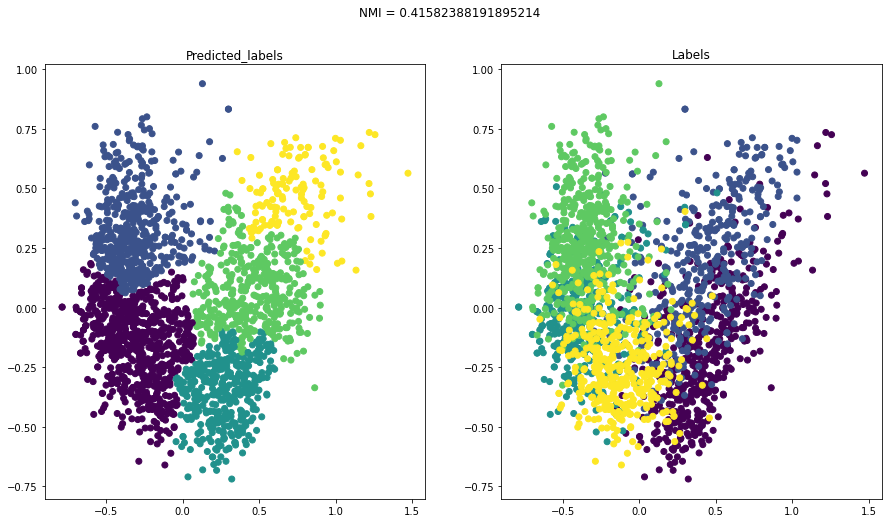

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X_glove_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

### TSNE

In [ ]:
from sklearn.manifold import TSNE
X_glove_reduced = TSNE(n_components=2, random_state=42).fit_transform(X_glove)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


#### TSNE + Kmeans 

normalized_mutual_info_score:  0.82 %
Accuracy:  0.94 %
Adjusted Rand Index:  0.85 %


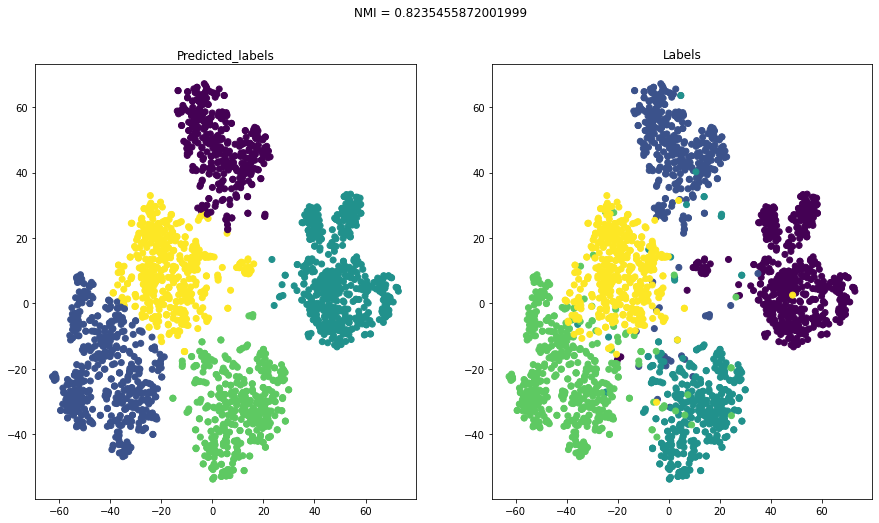

In [ ]:
pred_labels = KMeans(k,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

L'espace réduit obtenu par TSNE nous donne des classes plutôt bien séparées et relativement sphériques, ce qui explique que le Kmeans appliqué sur cet espace réduit nous donne de très bons résultats.

#### TSNE + Clustering spectral 

normalized_mutual_info_score:  0.83 %
Accuracy:  0.94 %
Adjusted Rand Index:  0.86 %


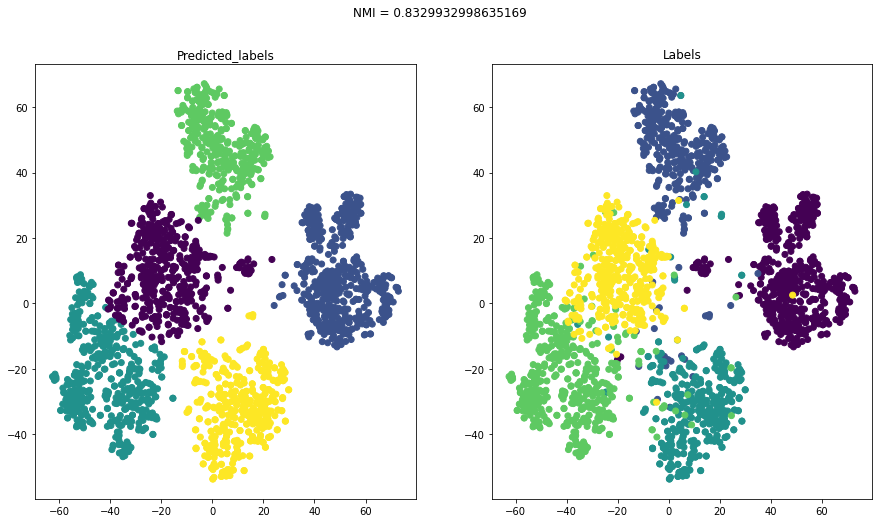

In [ ]:
pred_labels=SpectralClustering(k,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

#### TSNE + HDBSCAN

normalized_mutual_info_score:  0.76 %
Accuracy:  0.82 %
Adjusted Rand Index:  0.75 %


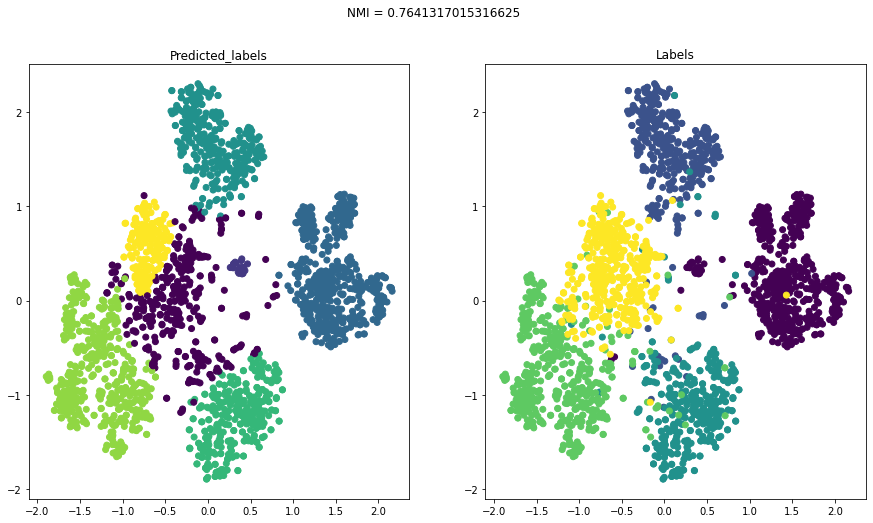

In [ ]:
X_glove_reduced_sc = StandardScaler().fit_transform(X_glove_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(X_glove_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced_sc,pred_labels, labels)


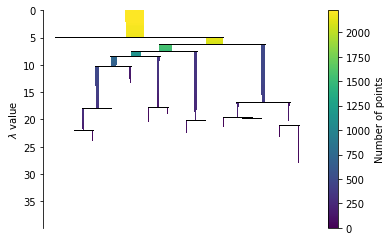

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### TSNE + CAH

normalized_mutual_info_score:  0.83 %
Accuracy:  0.94 %
Adjusted Rand Index:  0.85 %


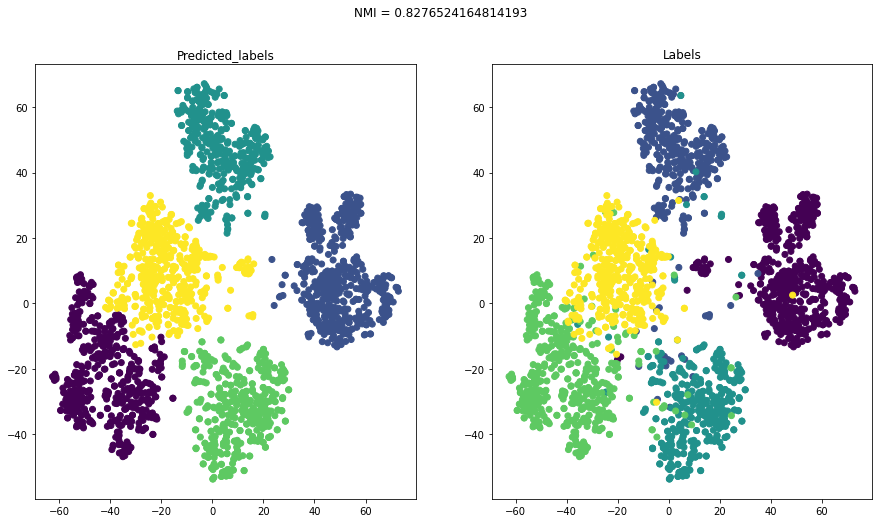

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(X_glove_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

### UMAP

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=dd9a04a3d016009346a6623b7d6a058f60bc2cb30867e7c67af090b007719cbc
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=52ebab13c13cc83638f4e8da83b5ed490427db4ed2b2dccc301a2973576804be
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP

X_glove_reduced = UMAP(n_components= 2, random_state=42).fit_transform(X_glove)

#### UMAP + Kmeans 

normalized_mutual_info_score:  0.87 %
Accuracy:  0.96 %
Adjusted Rand Index:  0.9 %


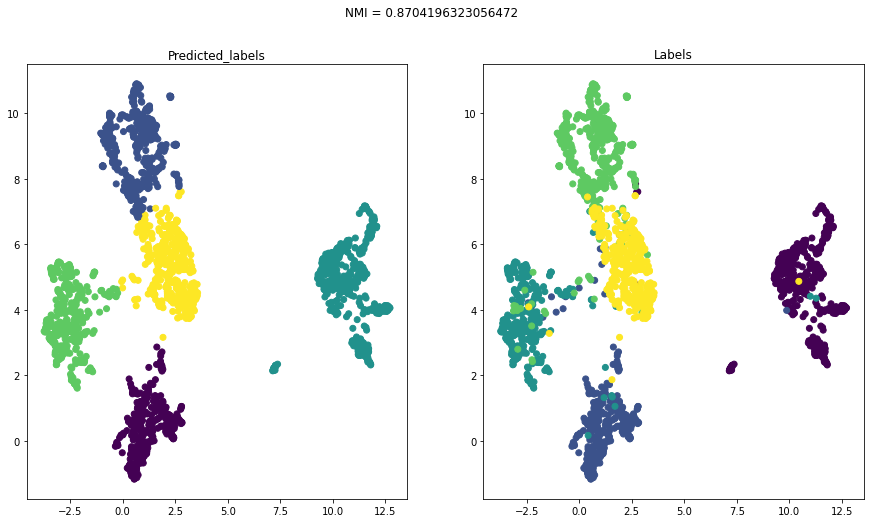

In [ ]:
pred_labels = KMeans(k,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

Là aussi, on obtient avec UMAP un espace réduit de très bonne qualité. Les clusters sont bien séparés entre eux (encore plus qu'avec TSNE) et relativement compacts.

#### UMAP + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.87 %
Accuracy:  0.96 %
Adjusted Rand Index:  0.9 %


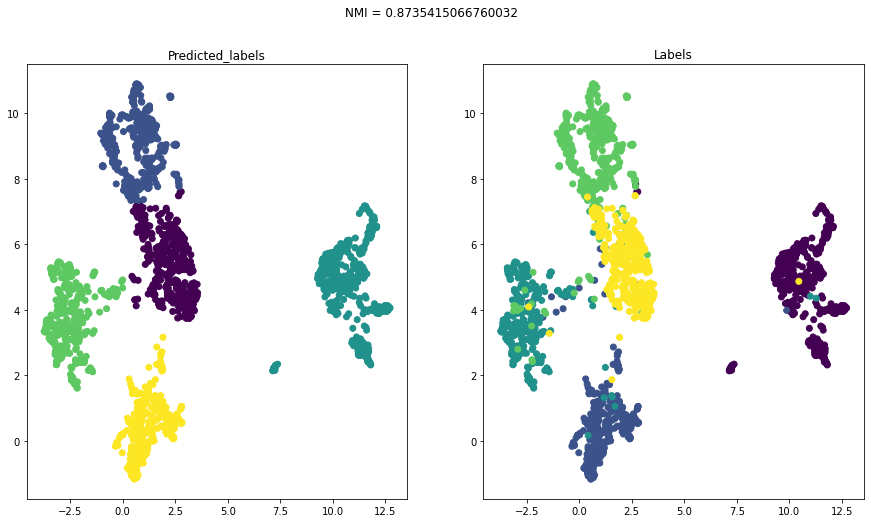

In [ ]:
pred_labels=SpectralClustering(k,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

#### UMAP + HDBSCAN

normalized_mutual_info_score:  0.79 %
Accuracy:  0.88 %
Adjusted Rand Index:  0.81 %


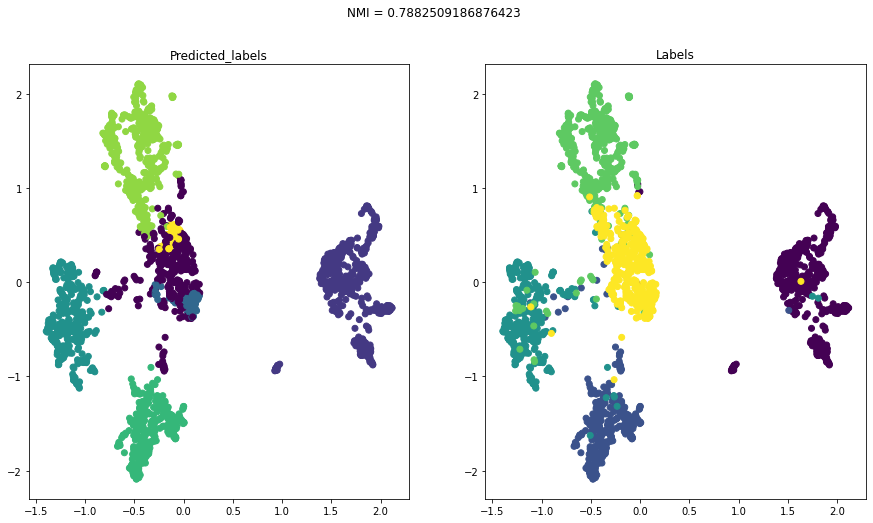

In [ ]:
X_glove_reduced_sc = StandardScaler().fit_transform(X_glove_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=30, cluster_selection_method='eom', metric='braycurtis').fit(X_glove_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced_sc,pred_labels, labels)


La densité des véritables clusters n'étant pas tout à fait homogène, HDBSCAN s'est fait avoir par endroit en identifiant de faux clusters dans les endroits où la densité était forte au sein d'un véritable cluster.

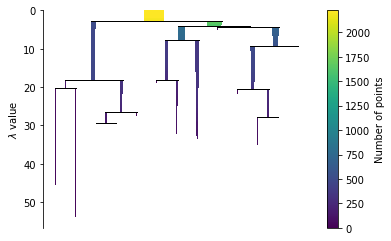

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### UMAP + CAH

normalized_mutual_info_score:  0.85 %
Accuracy:  0.95 %
Adjusted Rand Index:  0.87 %


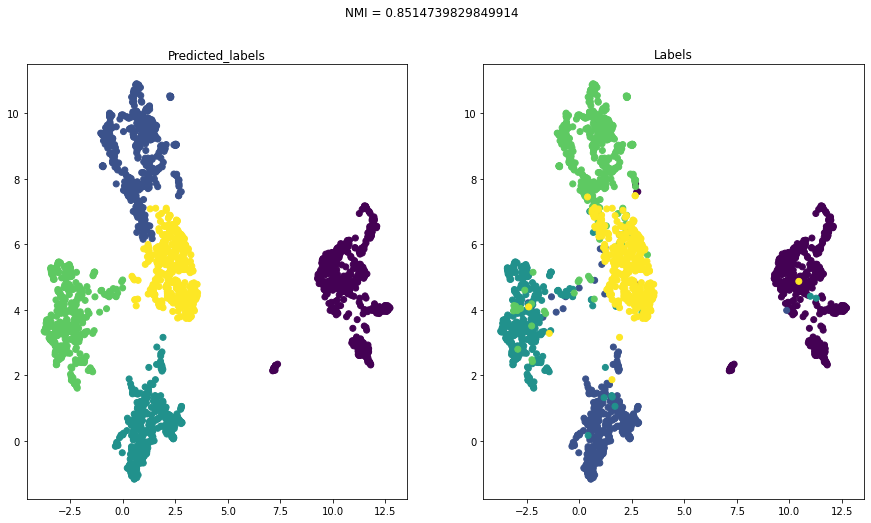

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(X_glove_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

### AutoEncoder

In [ ]:
X_glove_reduced = autoencoder(X_glove.astype("float32"), 2, seed=42)

100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


#### AutoEncoder + Kmeans

normalized_mutual_info_score:  0.58 %
Accuracy:  0.73 %
Adjusted Rand Index:  0.51 %


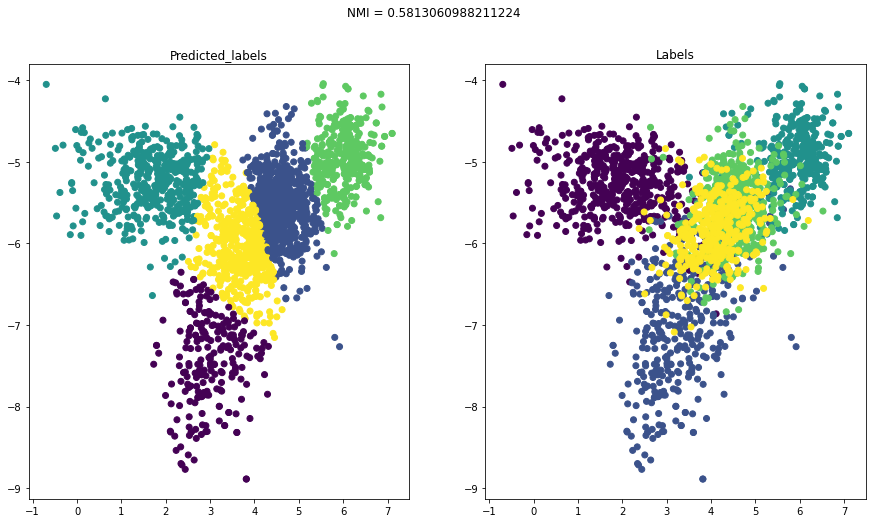

In [ ]:
pred_labels = KMeans(k,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

Comme la PCA précédemment, l'autoencoder n'a pas réussi à fournir un espace réduit de bonne qualité, les clusters sont mal séparés.

#### AutoEncoder + Clustering spectral 

normalized_mutual_info_score:  0.55 %
Accuracy:  0.64 %
Adjusted Rand Index:  0.43 %


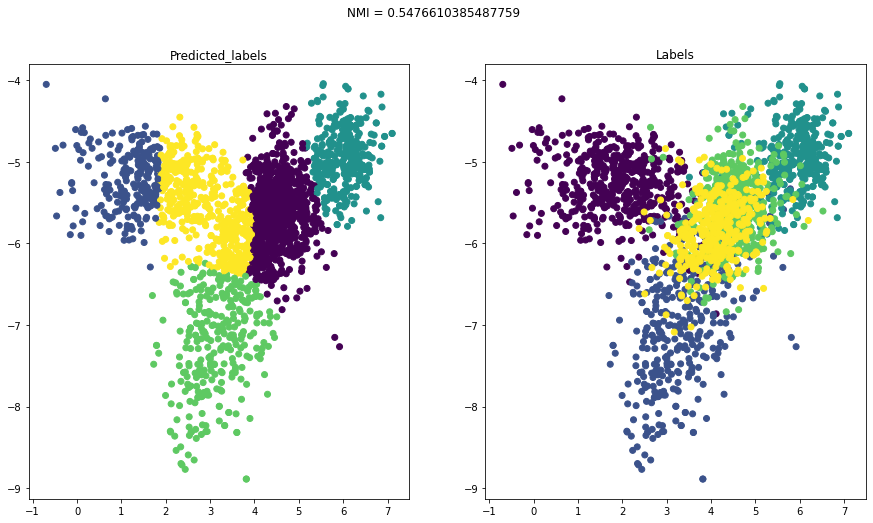

In [ ]:
pred_labels=SpectralClustering(k,affinity='nearest_neighbors',n_neighbors=30,random_state=42).fit(X_glove_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels, labels)

#### AutoEncoder + HDBSCAN

normalized_mutual_info_score:  0.5 %
Accuracy:  0.61 %
Adjusted Rand Index:  0.34 %


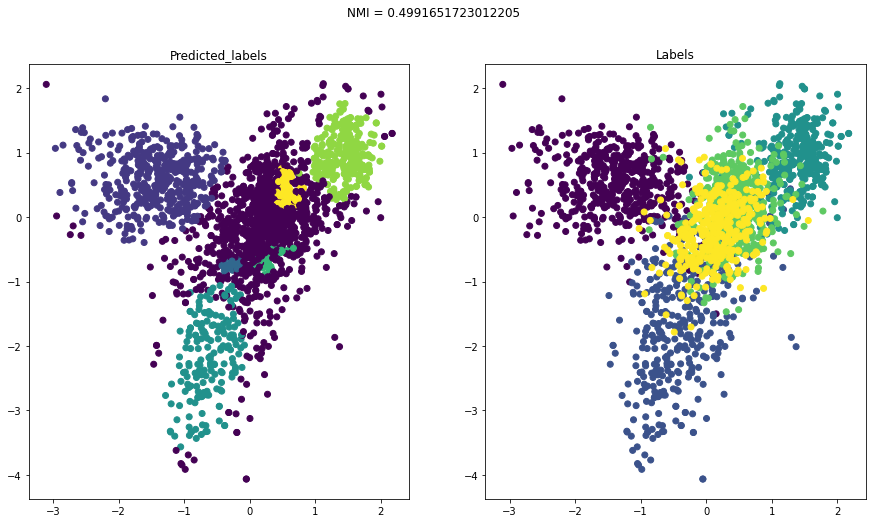

In [ ]:
X_glove_reduced_sc = StandardScaler().fit_transform(X_glove_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=25, cluster_selection_method='eom', metric='braycurtis').fit(X_glove_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced_sc,pred_labels, labels)


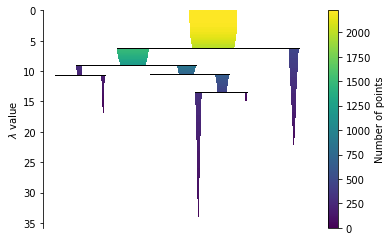

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### AutoEncoder + CAH

normalized_mutual_info_score:  0.56 %
Accuracy:  0.63 %
Adjusted Rand Index:  0.44 %


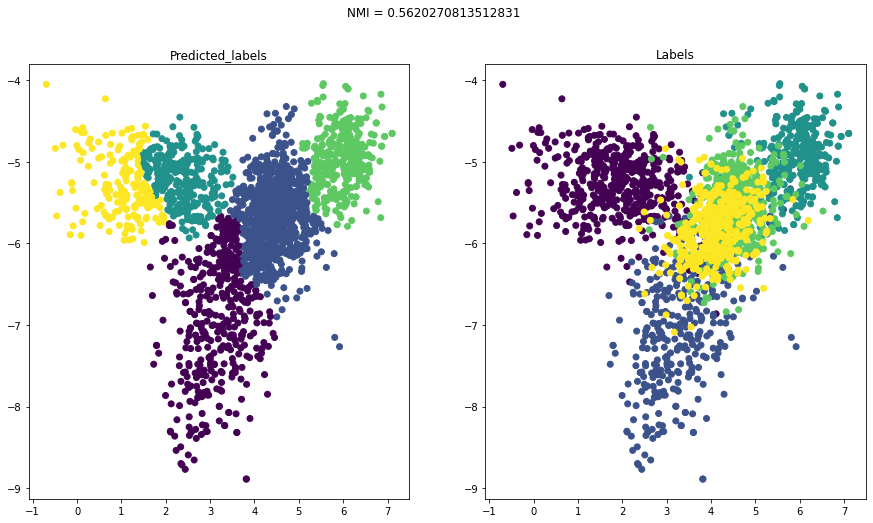

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward').fit(X_glove_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

### Conclusion sur les approches Tandem

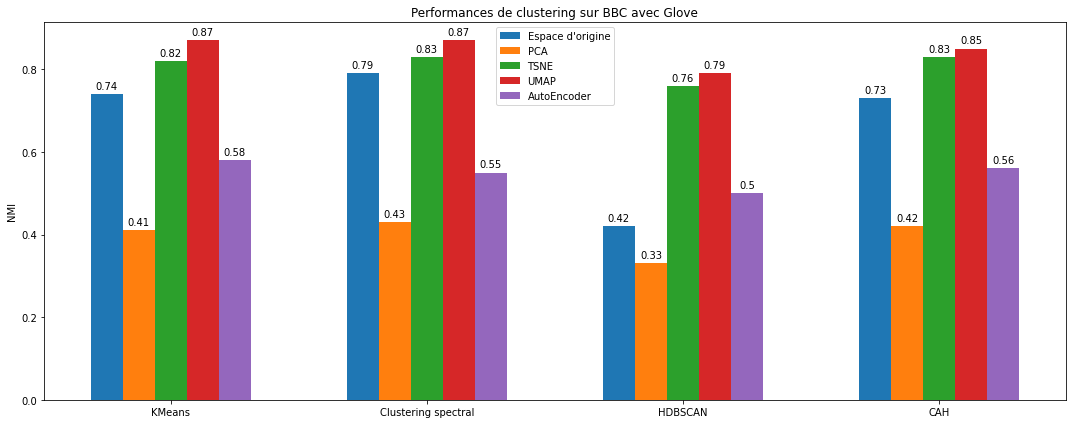

In [ ]:
clust_base = [0.74, 0.79, 0.42, 0.73]
pca_clust = [0.41, 0.43, 0.33, 0.42]
tsne_clust = [0.82, 0.83, 0.76, 0.83]
umap_clust = [0.87, 0.87, 0.79, 0.85]
autoenc_clust = [0.58, 0.55, 0.5, 0.56]
compareNMI(clust_base, pca_clust, tsne_clust, umap_clust, autoenc_clust, "Performances de clustering sur BBC avec Glove")

UMAP apparaît comme la meilleure technique de réduction de dimension, et permet d'améliorer sensiblement les résultats par rapport à un clustering sur l'espace d'origine. UMAP a donc trouvé un espace réduit intéressant pour la séparabilité des données.
KMeans, clustering spectral et CAH ont des performances similaires. HDBSCAN est moins bon, même s'il se rattrape pas mal quand il est couplé avec TSNE ou UMAP.

## Méthodes combinées

### Reduced K-means

  |======================================================================| 100%normalized_mutual_info_score:  0.54 %
Accuracy:  0.59 %
Adjusted Rand Index:  0.41 %


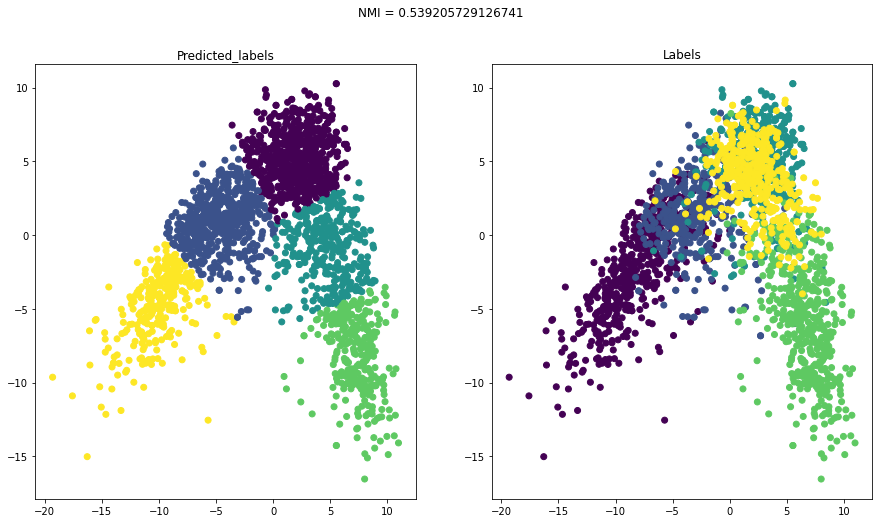

In [ ]:
rkm = fcps.TandemClustering(X_glove, k, Type='Reduced', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_glove_reduced = rkm[1][0]
#pred_labels= pred_labels - 1

printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

### Factorial K-means

  |======================================================================| 100%normalized_mutual_info_score:  0.48 %
Accuracy:  0.56 %
Adjusted Rand Index:  0.36 %


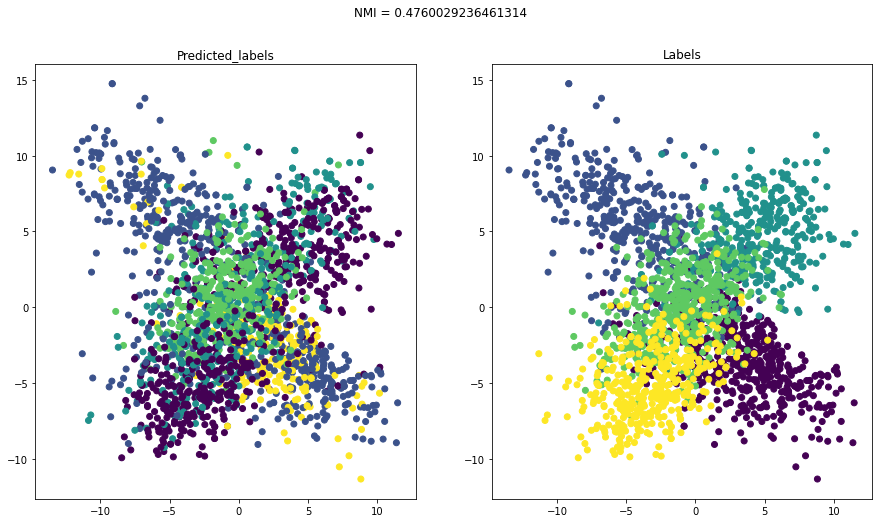

In [ ]:
rkm = fcps.TandemClustering(X_glove, k, Type='Factorial', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_glove_reduced = rkm[1][0]

printMetrics(labels,pred_labels)
eval_clustering_2D(X_glove_reduced,pred_labels,labels)

Reduced K-means et Factorial K-means n'ont pas obtenu de résultats satisfaisants.

### Deep K-Means (DKM)

In [ ]:
X_glove_reduced, cluster_assign = DKM(X_glove, k, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.92it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


In [ ]:
X_glove_reduced.shape

(2225, 2)

normalized_mutual_info_score:  0.75 %
Accuracy:  0.9 %
Adjusted Rand Index:  0.78 %


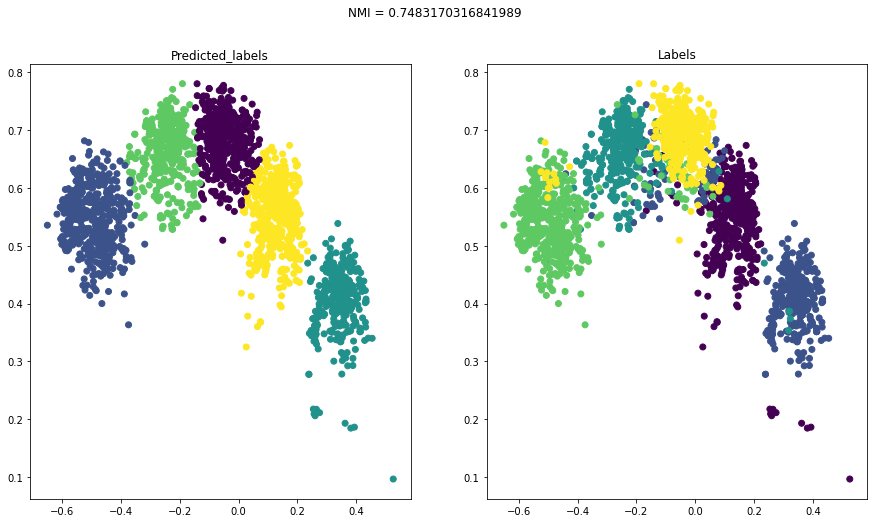

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_glove_reduced,cluster_assign,labels)

DKM a bien fonctionné, permettant d'avoir un espace réduit où l'on distingue bien les différents clusters.

### Deep Clustering Network (DCN)

In [ ]:
tf.reset_default_graph()

In [ ]:
X_glove_reduced, cluster_assign = DCN(X_glove, k, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]


normalized_mutual_info_score:  0.71 %
Accuracy:  0.88 %
Adjusted Rand Index:  0.72 %


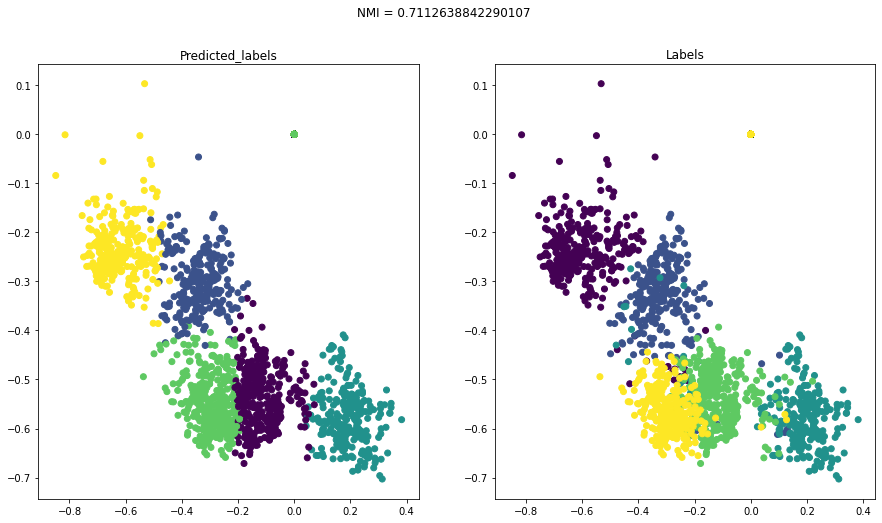

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_glove_reduced,cluster_assign,labels)

L'espace réduit et les performances obtenus par DCN sont assez similaires à ceux obtenus par DKM.

### Performances des approches combinées

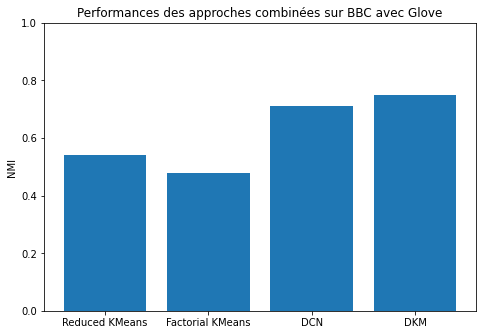

In [ ]:
perfs = [0.54, 0.48, 0.71, 0.75]
compareCombined(perfs, "Performances des approches combinées sur BBC avec Glove")

Les approches combinées "Deep" ont bien fonctionné, contrairement à Reduced KM et Factorial KM. Ceci-dit, on reste là aussi en dessous des meilleurs résultats obtenus par approches tandem.

# Conclusion générale

Sur le jeu de données BBC, les approches tandem obtiennent les meilleurs résultats. Elles surclassent le clustering sur l'espace d'origine ainsi que les méthodes combinées.

UMAP apparaît comme le meilleur algorithme de réduction de dimension, suivi de près par TSNE. A contrario, la PCA et l'autoencoder n'arrivent pas à obtenir de représentations réduites intéressantes.

Pour ce qui est des algorithmes de clustering, leurs performances sont assez similaires, hormis HDBSCAN qui a de mauvais résultats, ce qui indique que ce n'est sans doute pas le bon algorithme pour ce type de données textuelles.